# Segment Anything Model 2.1 (SAM2.1) - Parameter Tuning 

This notebook demonstrates how to use Meta's Segment Anything Model 2.1 (SAM2.1) for image segmentation and experiment with different parameter configurations to optimize results.

## Overview
- Load and use SAM2.1 for automatic mask generation
- Experiment with different parameters
- Visualize segmentation results
- Compare performance across parameter sets

## 1. Installation and Setup

In [6]:
# Install required packages
# !pip install segment-anything opencv-python matplotlib pillow torch torchvision numpy --break-system-packages

In [7]:
# Import necessary libraries
import torch
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image
# import requests
from io import BytesIO
import os
import time

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

PyTorch version: 2.9.1+cu128
CUDA available: True


## 2. Download SAM Model Checkpoint

In [8]:

#import the required libraries
from sam2.build_sam import build_sam2
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator


#specify the model configs and checkpoints
model_cfg = "configs/sam2.1/sam2.1_hiera_l.yaml"
sam2_checkpoint = "../checkpoints/sam2.1_hiera_large.pt"


## 3. Load Model and Image

In [11]:
# Set device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# Load SAM model
# use sam predictor for generating masks
sam2_model = build_sam2(model_cfg, sam2_checkpoint, device=device) 

sam2_model.to(device="cpu")

print("SAM model loaded successfully!")

Using device: cuda
SAM model loaded successfully!


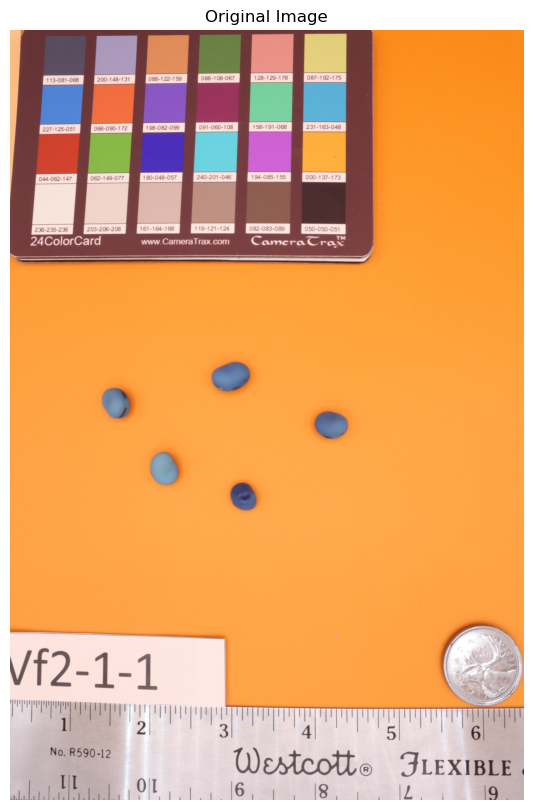

Image shape: (6000, 4000, 3)


In [15]:
# Load the image
image = cv2.imread(r"/home/AGR.GC.CA/bargotah/hkb/faba_images/Faba-Seed-CC_Vf2-1-1.JPG")

# Display the image
plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.axis('off')
plt.title('Original Image')
plt.show()

print(f"Image shape: {image.shape}")

## 4. Helper Functions for Visualization

In [16]:
def show_anns(anns, ax=None):
    """Display annotations with different colors for each mask"""
    if len(anns) == 0:
        return
    
    if ax is None:
        ax = plt.gca()
    
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    
    img = np.ones((sorted_anns[0]['segmentation'].shape[0], 
                   sorted_anns[0]['segmentation'].shape[1], 4))
    img[:, :, 3] = 0
    
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.5]])
        img[m] = color_mask
    
    ax.imshow(img)

def show_masks_on_image(image, masks, scores=None, point_coords=None):
    """Display masks overlaid on the original image"""
    fig, axes = plt.subplots(1, len(masks) + 1, figsize=(15, 5))
    
    axes[0].imshow(image)
    axes[0].set_title('Original Image')
    axes[0].axis('off')
    
    for i, (mask, ax) in enumerate(zip(masks, axes[1:])):
        ax.imshow(image)
        ax.imshow(mask, alpha=0.5, cmap='jet')
        if scores is not None:
            ax.set_title(f'Mask {i+1} (Score: {scores[i]:.3f})')
        else:
            ax.set_title(f'Mask {i+1}')
        
        if point_coords is not None:
            ax.plot(point_coords[0], point_coords[1], 'r*', markersize=15)
        
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

def compare_segmentations(image, results_dict):
    """Compare multiple segmentation results side by side"""
    n_results = len(results_dict)
    fig, axes = plt.subplots(1, n_results + 1, figsize=(5 * (n_results + 1), 5))
    
    # Original image
    axes[0].imshow(image)
    axes[0].set_title('Original Image', fontsize=12, fontweight='bold')
    axes[0].axis('off')
    
    # Segmentation results
    for idx, (name, masks) in enumerate(results_dict.items(), 1):
        axes[idx].imshow(image)
        show_anns(masks, ax=axes[idx])
        axes[idx].set_title(f'{name}\n({len(masks)} masks)', fontsize=10)
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.show()

## 5. Automatic Mask Generation with Default Parameters

Number of masks generated: 55
Time taken: 26.26 seconds

Mask properties: dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


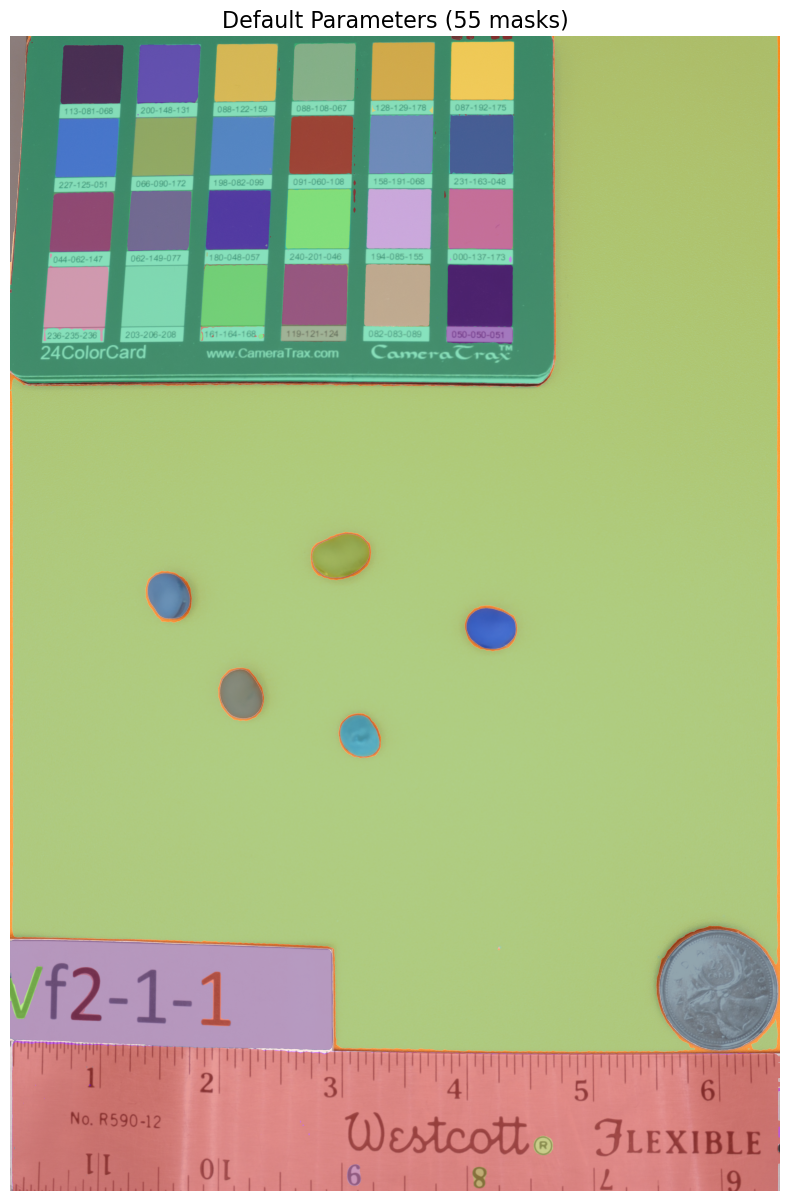

In [17]:
from sam2.build_sam import build_sam2
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator
# Generate masks
start_time = time.time()

mask_generator = SAM2AutomaticMaskGenerator(sam2_model)
masks_default = mask_generator.generate(image)

elapsed_time = time.time() - start_time

print(f"Number of masks generated: {len(masks_default)}")
print(f"Time taken: {elapsed_time:.2f} seconds")
print(f"\nMask properties: {masks_default[0].keys() if masks_default else 'No masks'}")

# Visualize
plt.figure(figsize=(15, 15))
plt.imshow(image)
show_anns(masks_default)
plt.axis('off')
plt.title(f'Default Parameters ({len(masks_default)} masks)', fontsize=16)
plt.show()

## 6. Parameter Tuning Experiments

### Key Parameters:
- **points_per_side**: Number of points sampled along each side of the image (higher = more masks)
- **pred_iou_thresh**: IoU threshold for filtering low-quality masks (higher = fewer but better masks)
- **stability_score_thresh**: Stability threshold for mask quality (higher = more stable masks)
- **crop_n_layers**: Number of layers for crop-based generation (more layers = better for small objects)
- **min_mask_region_area**: Minimum area for valid masks (filters out tiny segments)

### Experiment 1: Varying points_per_side


Testing points_per_side=16
Generated 34 masks in 8.83s

Testing points_per_side=32
Generated 55 masks in 25.13s

Testing points_per_side=64
Generated 96 masks in 90.92s


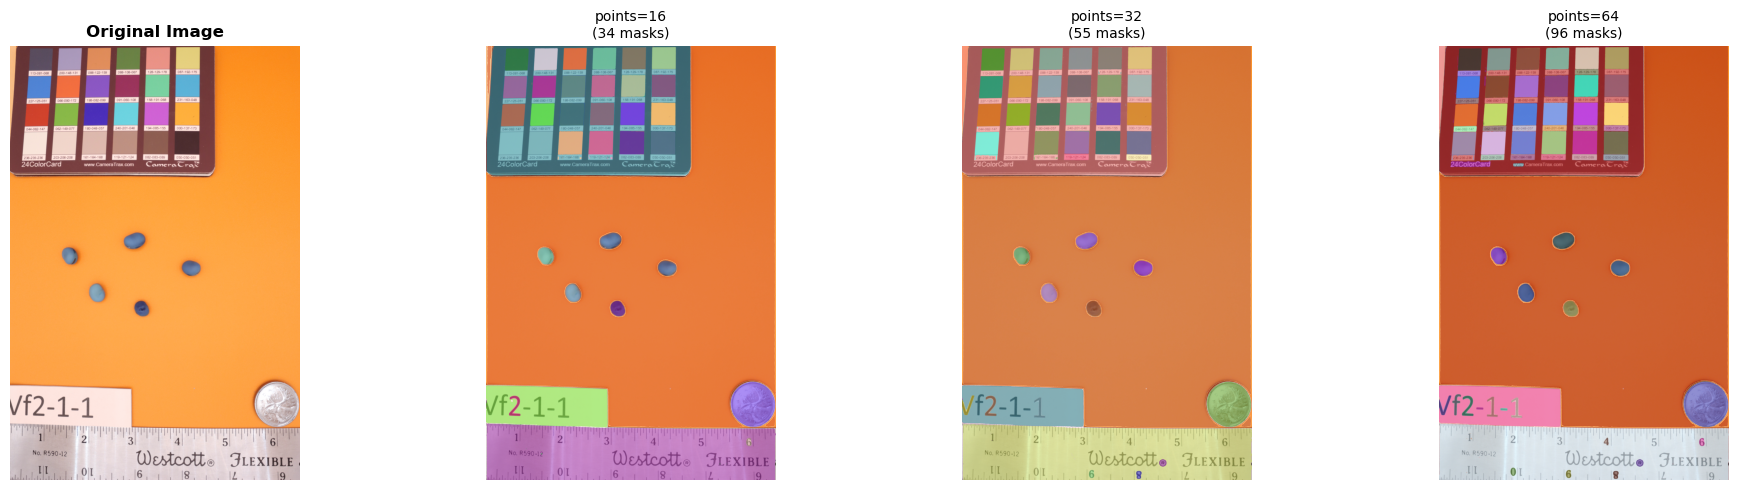

In [18]:
# Test different points_per_side values
points_per_side_values = [16, 32, 64]
results_points = {}

for points in points_per_side_values:
    print(f"\nTesting points_per_side={points}")

    mask_generator = SAM2AutomaticMaskGenerator(
        model=sam2_model,
        points_per_side=points,
    )
    
    start_time = time.time()
    masks = mask_generator.generate(image)
    elapsed_time = time.time() - start_time
    
    results_points[f"points={points}"] = masks
    print(f"Generated {len(masks)} masks in {elapsed_time:.2f}s")

# Compare results
compare_segmentations(image, results_points)

### Experiment 2: Varying points_per_batch


Testing points_per_batch=32
Generated 55 masks in 27.46s

Testing points_per_batch=64
Generated 55 masks in 24.57s

Testing points_per_batch=128
Generated 55 masks in 23.86s


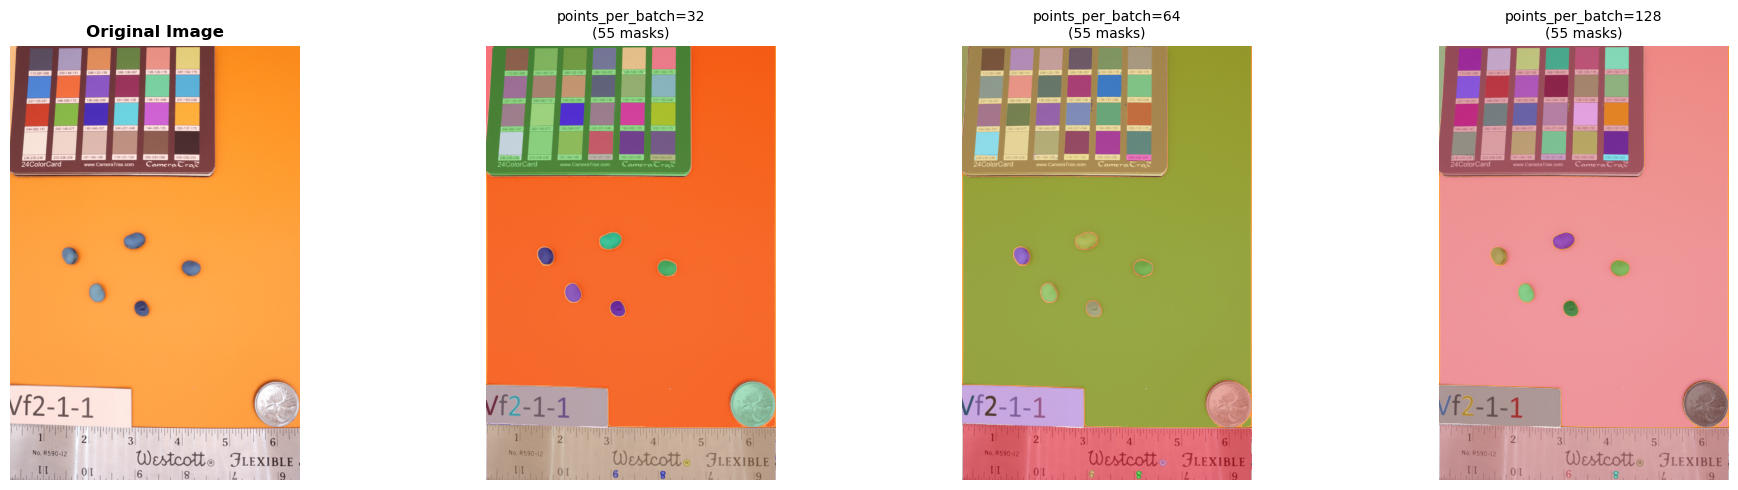

In [19]:
# points per batch
points_per_batch_values = [32, 64, 128]
results_ppb = {}

for ppb in points_per_batch_values:
    print(f"\nTesting points_per_batch={ppb}")

    mask_generator = SAM2AutomaticMaskGenerator(
        model=sam2_model,
        points_per_batch=ppb,
    )

    start_time = time.time()
    masks = mask_generator.generate(image)
    elapsed_time = time.time() - start_time

    results_ppb[f"points_per_batch={ppb}"] = masks
    print(f"Generated {len(masks)} masks in {elapsed_time:.2f}s")

# Compare results
compare_segmentations(image, results_ppb)



### Experiment 3: Varying pred_iou_thresh


Testing pred_iou_thresh=0.7
Generated 56 masks in 24.43s

Testing pred_iou_thresh=0.86
Generated 54 masks in 22.68s

Testing pred_iou_thresh=0.95
Generated 47 masks in 20.38s


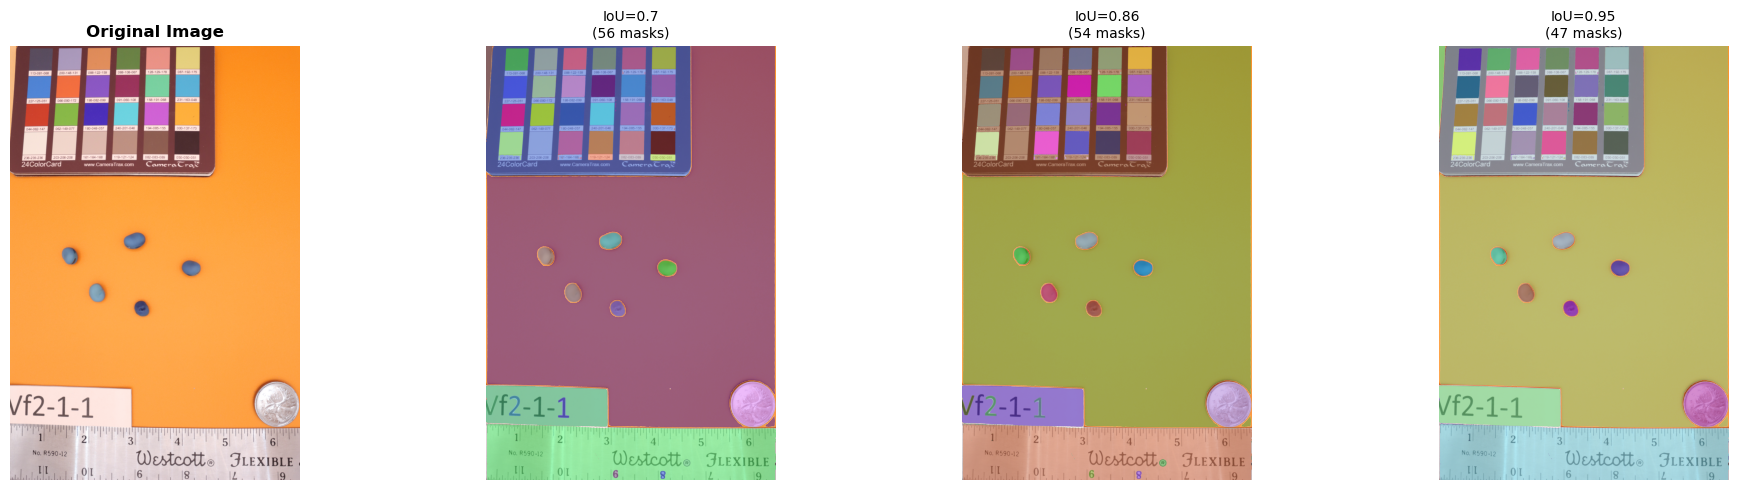

In [20]:
# Test different pred_iou_thresh values
iou_thresh_values = [0.7, 0.86, 0.95]
results_iou = {}

for iou_thresh in iou_thresh_values:    

    print(f"\nTesting pred_iou_thresh={iou_thresh}")
    
    mask_generator = SAM2AutomaticMaskGenerator(
        model=sam2_model,
        pred_iou_thresh=iou_thresh,
    )
    
    start_time = time.time()
    masks = mask_generator.generate(image)
    elapsed_time = time.time() - start_time
    
    results_iou[f"IoU={iou_thresh}"] = masks
    print(f"Generated {len(masks)} masks in {elapsed_time:.2f}s")

# Compare results
compare_segmentations(image, results_iou)

### Experiment 4: Varying stability_score_thresh


Testing stability_score_thresh=0.8
Generated 66 masks in 30.86s

Testing stability_score_thresh=0.92
Generated 60 masks in 24.62s

Testing stability_score_thresh=0.98
Generated 30 masks in 22.12s


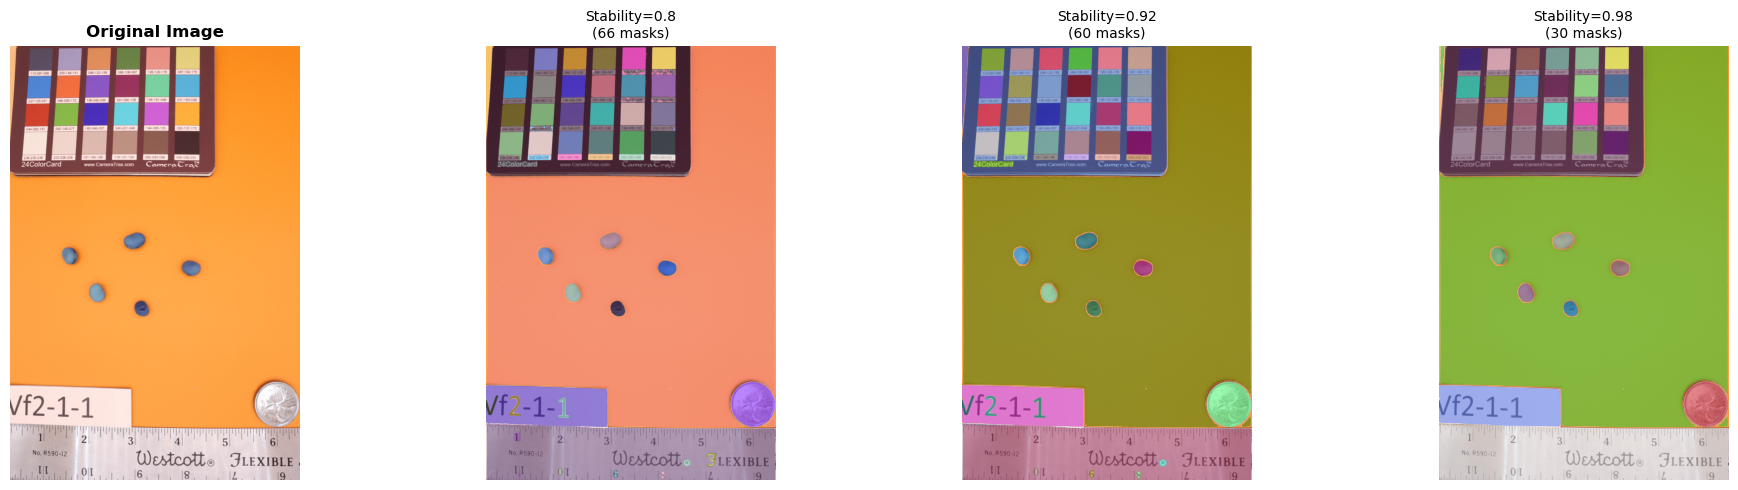

In [21]:
# Test different stability_score_thresh values
stability_values = [0.80, 0.92, 0.98]
results_stability = {}

for stability in stability_values:
    print(f"\nTesting stability_score_thresh={stability}")
    
    mask_generator = SAM2AutomaticMaskGenerator(
        model=sam2_model,
        stability_score_thresh=stability,
    )
    
    start_time = time.time()
    masks = mask_generator.generate(image)
    elapsed_time = time.time() - start_time
    
    results_stability[f"Stability={stability}"] = masks
    print(f"Generated {len(masks)} masks in {elapsed_time:.2f}s")

# Compare results
compare_segmentations(image, results_stability)

### Experiment 5: Varying poinbox_nms_thresh


Testing box_nms_thresh=0.5
Generated 48 masks in 24.73s

Testing box_nms_thresh=0.7
Generated 55 masks in 24.50s

Testing box_nms_thresh=0.9
Generated 64 masks in 24.01s


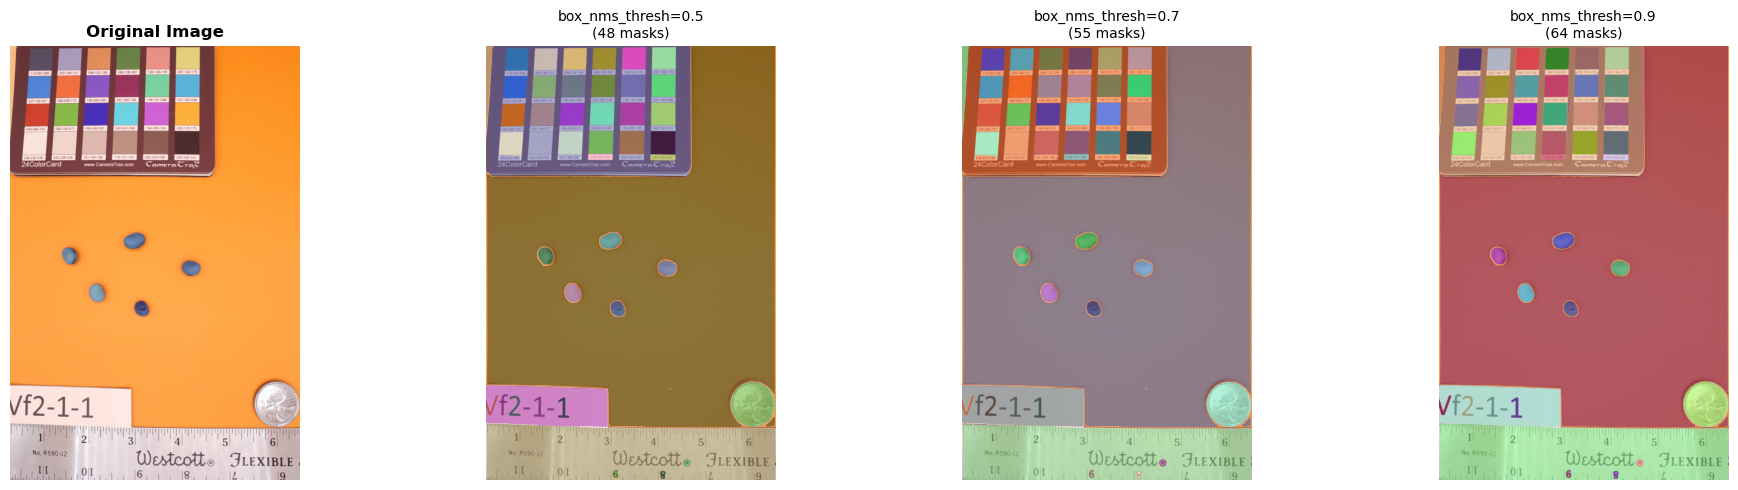

In [22]:
# box nums thresh
box_nms_thresh_values = [0.5, 0.7, 0.9]
results_box_nms = {}

for thresh in box_nms_thresh_values:
    print(f"\nTesting box_nms_thresh={thresh}")

    mask_generator = SAM2AutomaticMaskGenerator(
        model=sam2_model,
        box_nms_thresh=thresh,
    )

    start_time = time.time()
    masks = mask_generator.generate(image)
    elapsed_time = time.time() - start_time

    results_box_nms[f"box_nms_thresh={thresh}"] = masks
    print(f"Generated {len(masks)} masks in {elapsed_time:.2f}s")

# Compare results
compare_segmentations(image, results_box_nms)


### Experiment 6: Varying min_mask_region_area


Testing min_mask_region_area=0
Generated 55 masks in 24.68s

Testing min_mask_region_area=100


/data/home/AGR.GC.CA/bargotah/faba-bean-FE-pipeline/sam2/sam2/sam2_image_predictor.py:431: UserWarning: cannot import name '_C' from 'sam2' (/data/home/AGR.GC.CA/bargotah/faba-bean-FE-pipeline/sam2/sam2/__init__.py)

Skipping the post-processing step due to the error above. You can still use SAM 2 and it's OK to ignore the error above, although some post-processing functionality may be limited (which doesn't affect the results in most cases; see https://github.com/facebookresearch/sam2/blob/main/INSTALL.md).
  masks = self._transforms.postprocess_masks(


Generated 55 masks in 24.36s

Testing min_mask_region_area=500
Generated 55 masks in 23.81s


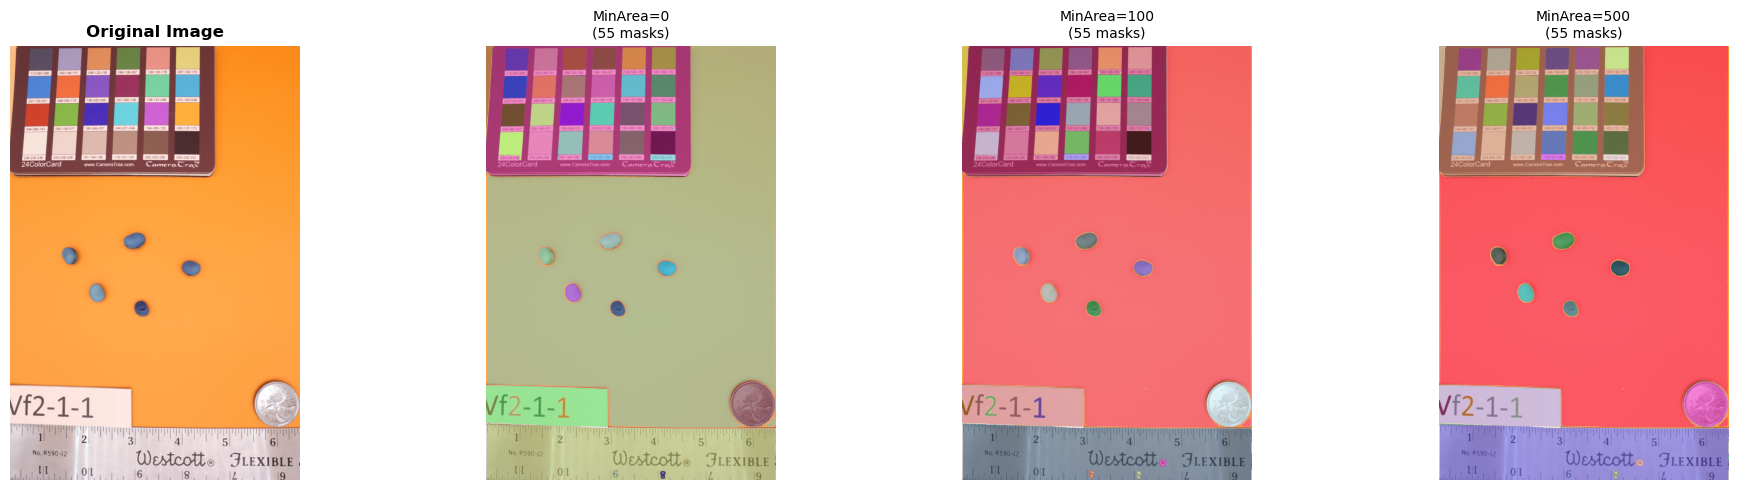

In [23]:
# Test different min_mask_region_area values
min_area_values = [0, 100, 500]
results_area = {}

for min_area in min_area_values:
    print(f"\nTesting min_mask_region_area={min_area}")
    
    mask_generator = SAM2AutomaticMaskGenerator(
        model=sam2_model,
        min_mask_region_area=min_area,
    )
    
    start_time = time.time()
    masks = mask_generator.generate(image)
    elapsed_time = time.time() - start_time
    
    results_area[f"MinArea={min_area}"] = masks
    print(f"Generated {len(masks)} masks in {elapsed_time:.2f}s")

# Compare results
compare_segmentations(image, results_area)

### Experiment 7: Varying crop_nms_thresh


Testing crop_nms_thresh=0.5
Generated 55 masks in 24.67s

Testing crop_nms_thresh=0.7
Generated 55 masks in 24.69s

Testing crop_nms_thresh=0.9
Generated 55 masks in 23.80s


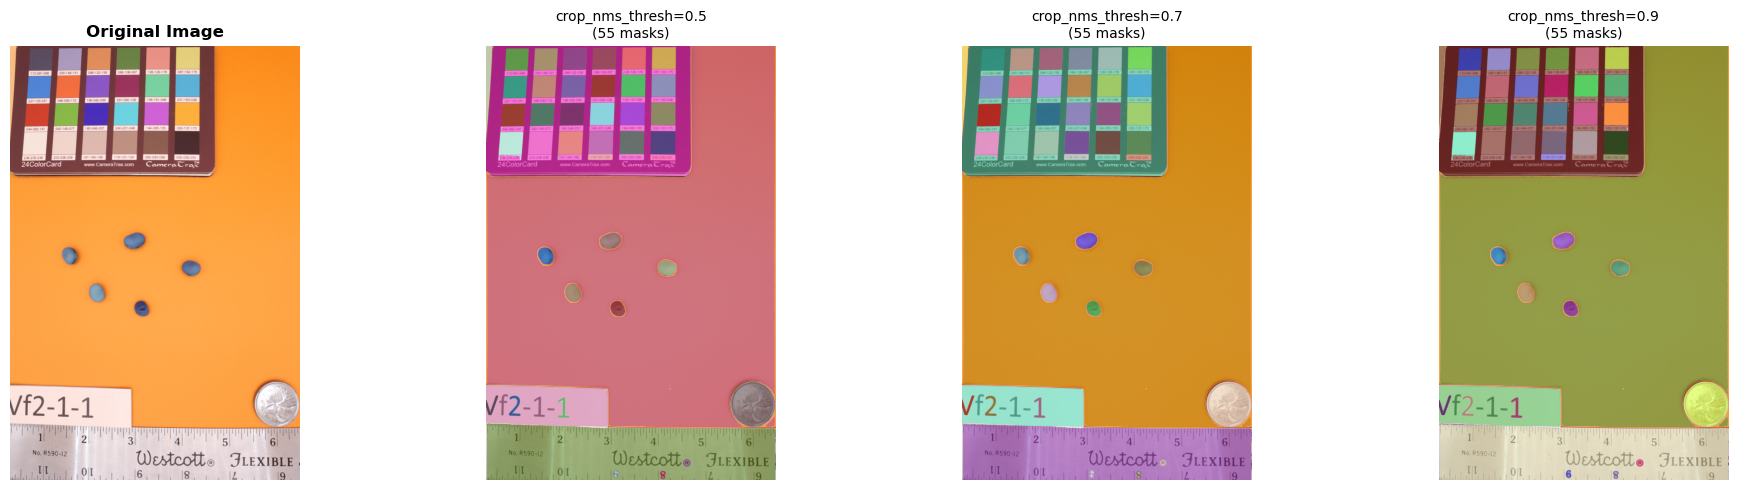

In [24]:
#  crop nms thresh
crop_nms_thresh_values = [0.5, 0.7, 0.9]
results_crop_nms = {}

for thresh in crop_nms_thresh_values:
    print(f"\nTesting crop_nms_thresh={thresh}")

    mask_generator = SAM2AutomaticMaskGenerator(
        model=sam2_model,
        crop_nms_thresh=thresh,
    )

    start_time = time.time()
    masks = mask_generator.generate(image)
    elapsed_time = time.time() - start_time

    results_crop_nms[f"crop_nms_thresh={thresh}"] = masks
    print(f"Generated {len(masks)} masks in {elapsed_time:.2f}s")

# Compare results
compare_segmentations(image, results_crop_nms)


## 7. Optimized Parameter Configuration


Testing High Quality configuration...
Generated 136 masks in 133.32s

Testing Balanced configuration...
Generated 60 masks in 23.35s

Testing Fast configuration...
Generated 33 masks in 7.81s


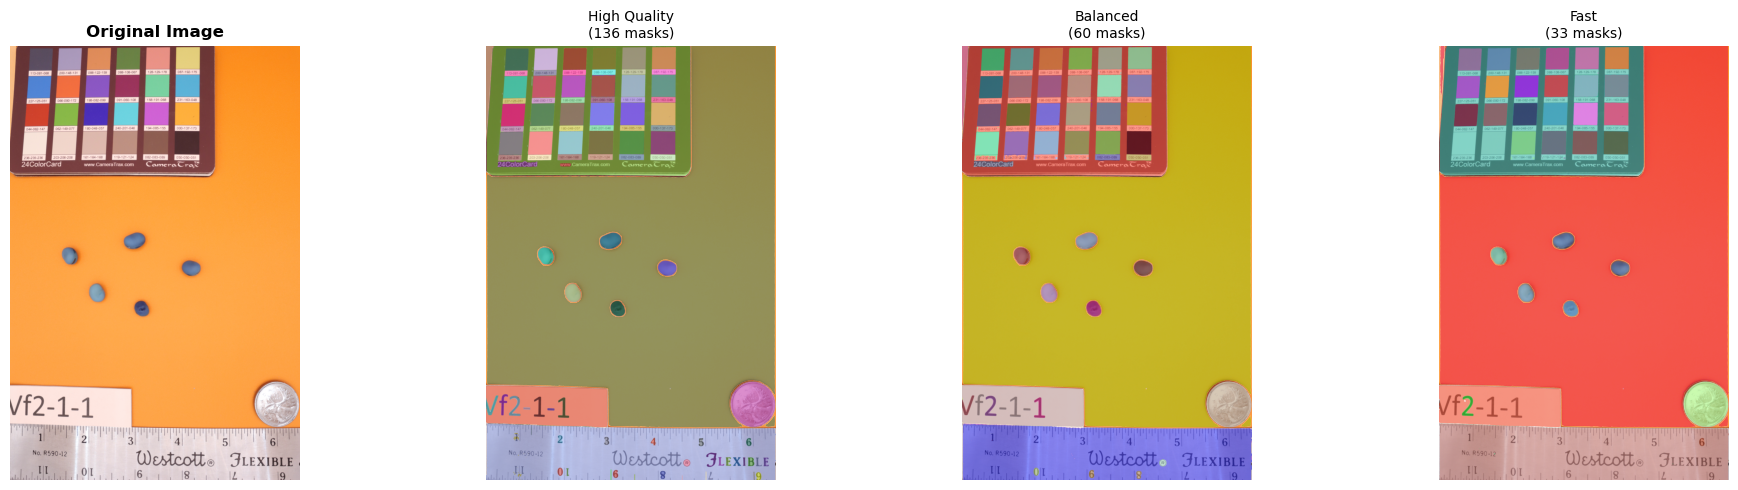

In [25]:
# Configuration 1: High Quality (more masks, slower)
mask_generator_hq = SAM2AutomaticMaskGenerator(
    model=sam2_model,
    points_per_side=64,
    pred_iou_thresh=0.88,
    stability_score_thresh=0.92,
    box_nms_thresh=0.7,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=100,
)

# Configuration 2: Balanced (good quality, moderate speed)
mask_generator_balanced = SAM2AutomaticMaskGenerator(
    model=sam2_model,
    points_per_side=32,
    pred_iou_thresh=0.86,
    stability_score_thresh=0.90,
    box_nms_thresh=0.7,
    crop_n_layers=0,
    min_mask_region_area=200,
)

# Configuration 3: Fast (fewer masks, faster)
mask_generator_fast = SAM2AutomaticMaskGenerator(
    model=sam2_model,
    points_per_side=16,
    pred_iou_thresh=0.90,
    stability_score_thresh=0.95,
    box_nms_thresh=0.7,
    crop_n_layers=0,
    min_mask_region_area=500,
)

# Generate masks with each configuration
configs = {
    "High Quality": mask_generator_hq,
    "Balanced": mask_generator_balanced,
    "Fast": mask_generator_fast
}

results_optimized = {}

for config_name, generator in configs.items():
    print(f"\nTesting {config_name} configuration...")
    start_time = time.time()
    masks = generator.generate(image)
    elapsed_time = time.time() - start_time
    
    results_optimized[config_name] = masks
    print(f"Generated {len(masks)} masks in {elapsed_time:.2f}s")

# Compare optimized configurations
compare_segmentations(image, results_optimized)

## 10. Performance Analysis


High Quality Statistics:
Number of masks: 136
Average area: 291475.89 pixels
Average stability score: 0.9702
Average predicted IoU: 0.9580

Balanced Statistics:
Number of masks: 60
Average area: 604345.58 pixels
Average stability score: 0.9706
Average predicted IoU: 0.9681

Fast Statistics:
Number of masks: 33
Average area: 869522.00 pixels
Average stability score: 0.9781
Average predicted IoU: 0.9738


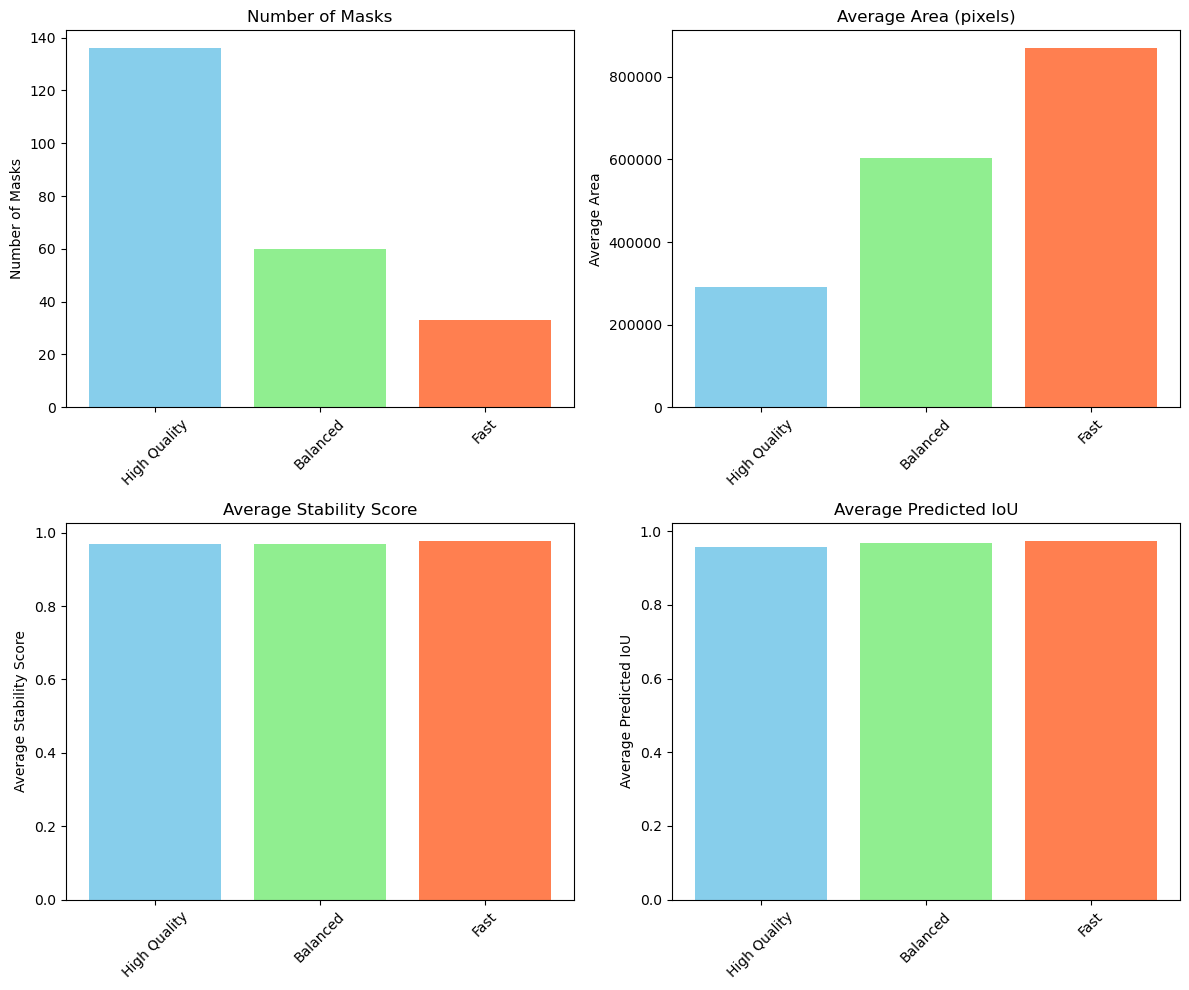

In [26]:
# Analyze mask statistics
def analyze_masks(masks, config_name):
    areas = [m['area'] for m in masks]
    stability_scores = [m['stability_score'] for m in masks]
    pred_ious = [m['predicted_iou'] for m in masks]
    
    print(f"\n{config_name} Statistics:")
    print(f"Number of masks: {len(masks)}")
    print(f"Average area: {np.mean(areas):.2f} pixels")
    print(f"Average stability score: {np.mean(stability_scores):.4f}")
    print(f"Average predicted IoU: {np.mean(pred_ious):.4f}")
    
    return {
        'count': len(masks),
        'avg_area': np.mean(areas),
        'avg_stability': np.mean(stability_scores),
        'avg_iou': np.mean(pred_ious)
    }

# Analyze all optimized configurations
stats = {}
for config_name, masks in results_optimized.items():
    stats[config_name] = analyze_masks(masks, config_name)

# Create comparison plot
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

configs_list = list(stats.keys())
metrics = ['count', 'avg_area', 'avg_stability', 'avg_iou']
titles = ['Number of Masks', 'Average Area (pixels)', 'Average Stability Score', 'Average Predicted IoU']

for idx, (metric, title) in enumerate(zip(metrics, titles)):
    ax = axes[idx // 2, idx % 2]
    values = [stats[config][metric] for config in configs_list]
    ax.bar(configs_list, values, color=['skyblue', 'lightgreen', 'coral'])
    ax.set_title(title)
    ax.set_ylabel(title.split('(')[0].strip())
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()